## Initial setup and modules/packages loading

In [274]:
# Setup

%matplotlib inline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import category_encoders as ce 
#import folium

# for ML:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score

from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA



from sklearn.preprocessing import StandardScaler, normalize




from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import f1_score


## Function

In [275]:
def avg_score(X,y, model, scale, scaler=None): #mean value for train and test (to apply kfold to better compare results)
    vec_score_train = []
    vec_score_test = []
    vec_f1_score=[]
    
    method=KFold(n_splits=10, shuffle=True, random_state=123)
    
    for train_index, val_index in method.split(X): #KFold separates the data into 10 train and test subsets (indexes)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index] #keeping the indexes of new split
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
       
        if scale==True:
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
 
        model.fit(X_train, y_train) 
        train_score=model.score(X_train, y_train)
        val_score=model.score(X_val, y_val)
                
        vec_score_train.append(train_score)
        vec_score_test.append(val_score)

    print('Score for: \n', model)
    print('Train:', round(np.mean(train_score), 4)) 
    print('Test :', round(np.mean(val_score),  4), '\n')




## Data understanding

**Data fields**
- Patient_ID - The unique identifier of the patient
- Family_Case_ID - The family identification
- Severity - The severity of the disease, where 1 is the lowest and 3 the highest severity
- Name - The name of the patient
- Birthday_year - The year of birthday of the patient
- Parents_Siblings_Infected - The number of parents and/or siblings infected
- Partner_Children_Infected - The number of partner and/or children infected
- Medical_Expenses_Family - The medical expenses associated to try to contain the epidemy on the family
- Medical_Tent - The medical tent where the patient is / was lodged
- City - The original city of the patient
- Deceased - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

In [276]:
data = pd.read_csv('train.csv', sep =',', skipinitialspace=True)
test = pd.read_csv('test.csv', sep =',', skipinitialspace=True)


In [277]:
data.head(2)

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0


In [278]:
test.head(2)

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe


In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
Patient_ID                           900 non-null int64
Family_Case_ID                       900 non-null int64
Severity                             900 non-null int64
Name                                 900 non-null object
Birthday_year                        723 non-null float64
Parents or siblings infected         900 non-null int64
Wife/Husband or children infected    900 non-null int64
Medical_Expenses_Family              900 non-null int64
Medical_Tent                         198 non-null object
City                                 898 non-null object
Deceased                             900 non-null int64
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [280]:
data.shape

(900, 11)

In [281]:
#checking missing values
nulls = data.isna().sum()
print(nulls[nulls > 0])

Birthday_year    177
Medical_Tent     702
City               2
dtype: int64


**Comment:**
- medical tent has moret han 78% of null values. This columns will not be used
- almost 20% of birthday data is null

- also, the column name and patient id are not relevant for this, therefore will be dropped as well

In [282]:
data = data.drop(['Medical_Tent', 'Name', 'Patient_ID'], axis=1)
test_ = test.drop(['Medical_Tent', 'Name', 'Patient_ID'], axis=1)

**About the test**

In [283]:
#checking missing values
nulls = test_.isna().sum()
print(nulls[nulls > 0])

Birthday_year    82
dtype: int64


### Dealing with nulls

-filling birthday null asn dropping cities



In [284]:
data_null = data.copy(deep=True)

#### Filling birthday nulls

In [285]:
data_null.columns

Index(['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'City', 'Deceased'],
      dtype='object')

In [286]:
data_null.head(2)

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,City,Deceased
0,4696,3,NaN,0,0,225,Santa Fe,1
1,21436,1,1966.0,0,1,1663,Albuquerque,0


In [290]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

data1 = pd.DataFrame(imputer.fit_transform(data_null[['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family']]), columns = ['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family'])


test1 = pd.DataFrame(imputer.fit_transform(test_[['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family']]), columns = ['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family'])

In [292]:
data_null = data_null.drop(['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family'],axis=1)
data_null = data_null.merge(data1, right_index= True, left_index = True)


In [293]:
data_null['Birthday_year'] = round(data_null['Birthday_year'],0)

test1['Birthday_year'] = round(test1['Birthday_year'],0)

In [294]:
test_ = test_.drop(['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family'],axis=1)
test_ = test_.merge(test1, right_index= True, left_index = True)

In [295]:
data_null.head(2)

,City,Deceased,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
0,Santa Fe,1,4696.0,3.0,1993.0,0.0,0.0,225.0
1,Albuquerque,0,21436.0,1.0,1966.0,0.0,1.0,1663.0


In [296]:
#checking missing values
nulls = data_null.isna().sum()
print(nulls[nulls > 0])

City    2
dtype: int64


In [297]:
#checking missing values
nulls = test_.isna().sum()
print(nulls[nulls > 0])

Series([], dtype: int64)


In [298]:
data_null = data_null.dropna(axis=0)

In [299]:
#checking missing values
nulls = data_null.isna().sum()
print(nulls[nulls > 0])

Series([], dtype: int64)


#### Data with no null

In [300]:
data = data_null.copy(deep=True)

## Glance on the dataset values

In [257]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data)
profile

C:\Users\Fernanda\.conda\envs\DV_envi\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,9
Number of observations,898
Total Missing (%),0.0%
Total size in memory,63.3 KiB
Average record size in memory,72.1 B
Numeric,7
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,0


#### Comment:

blabalbala


In [258]:
data.groupby('Deceased').mean()

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,
0,13564.257971,1.968116,1991.660870,0.466667,0.478261,1335.542029
1,14736.466546,2.533454,1989.493671,0.327306,0.549729,616.504521


In [259]:
data.groupby('Deceased').median()

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,
0,13465.0,2.0,1992.0,0.0,0.0,728.0
1,13911.0,3.0,1991.0,0.0,0.0,294.0


#### Comment:

- The group that do not died from this disease **spends more** and has a **less severe** disease
- Birthday and infected parents do not seem to play an important role in differentiating groups

## Outliers



## Data exploration

In [260]:
#function to calculate the percentage 
def perc_table(index, columns, values):
    perc_table = pd.crosstab(index = index, 
                     columns = columns, 
                     values = values, 
                     aggfunc='count', 
                     normalize='columns').applymap('{:.3}'.format)
    return perc_table

In [261]:
data.columns

Index(['City', 'Deceased', 'Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family'],
      dtype='object')

In [157]:
perc_table(data['Deceased'],data['City'],data.index)

City,Albuquerque,Santa Fe,Taos
Deceased,,,
0,0.556,0.341,0.375
1,0.444,0.659,0.625


In [158]:
perc_table(data['Deceased'],data['Severity'],data.index)

Severity,1.0,2.0,3.0
Deceased,,,
0,0.626,0.473,0.247
1,0.374,0.527,0.753


In [159]:
perc_table(data['Deceased'],data['Parents or siblings infected'],data.index)

Parents or siblings infected,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Deceased,,,,,,,
0,0.343,0.558,0.5,0.6,0.0,0.2,0.0
1,0.657,0.442,0.5,0.4,1.0,0.8,1.0


In [160]:
perc_table(data['Deceased'],data['Wife/Husband or children infected'],data.index)

Wife/Husband or children infected,0.0,1.0,2.0,3.0,4.0,5.0,8.0
Deceased,,,,,,,
0,0.343,0.542,0.464,0.25,0.167,0.0,0.0
1,0.657,0.458,0.536,0.75,0.833,1.0,1.0


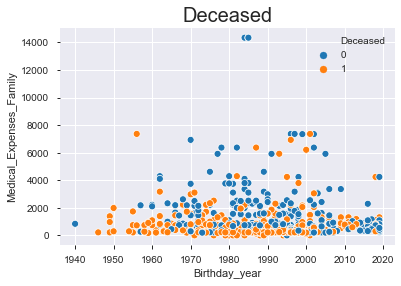

In [161]:
%matplotlib inline  
plt.title("Deceased", fontdict = {'fontsize': 20})
ax = sns.scatterplot(x="Birthday_year", y="Medical_Expenses_Family", data=data, hue ='Deceased' )

## X & y

In [301]:
# Separate features and predicted value
X = data.drop(['Deceased'], axis=1)
y = data[["Deceased"]]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                   test_size=0.2, 
                                                   random_state = 123, 
                                                    shuffle=True
                                                   )

## Encoder

### Encoder X 

In [302]:
data.columns

Index(['City', 'Deceased', 'Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family'],
      dtype='object')

In [303]:
cat_features=['City' ]
# Encoder 
ce_one_hot = ce.OneHotEncoder(cols = cat_features, use_cat_names=True)
data_encoder = ce_one_hot.fit_transform(X)
data_encoder.columns

Index(['City_Santa Fe', 'City_Albuquerque', 'City_Taos', 'Family_Case_ID',
       'Severity', 'Birthday_year', 'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family'],
      dtype='object')

In [304]:
data_encoder = data_encoder.drop(['City_Albuquerque'],axis= 1)

In [305]:
X= data_encoder.copy(deep=True)

### Encouder X_train, X_val, y_train and y_val

- To analyse the selection features and in the selecting model

In [306]:
# Encoder 
ce_train = ce.OneHotEncoder(cols = cat_features, use_cat_names=True)
data_encoder_train = ce_train.fit_transform(X_train)
data_encoder_train = data_encoder_train.drop(['City_Albuquerque'],axis= 1)
X_train= data_encoder_train.copy(deep=True)


In [307]:
data_encoder_val = ce_train.transform(X_val)
data_encoder_val = data_encoder_val.drop(['City_Albuquerque'],axis= 1)
X_val= data_encoder_val.copy(deep=True)
X_val.head(2)

,City_Santa Fe,City_Taos,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
41,1,0,14413.0,1.0,1981.0,0.0,1.0,1565.0
253,1,0,22451.0,3.0,1994.0,0.0,0.0,220.0


**For the test set**

In [308]:
data_encoder_val = ce_train.transform(test_)
data_encoder_val = data_encoder_val.drop(['City_Albuquerque'],axis= 1)
test_= data_encoder_val.copy(deep=True)
test_.head(2)

,City_Santa Fe,City_Taos,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
0,1,0,49242.0,3.0,1984.0,0.0,0.0,203.0
1,1,0,10400.0,3.0,1988.0,0.0,0.0,631.0


## Select feature

In [309]:
Dependent = y_train.copy(deep = True)
Independet = X_train.copy(deep=True)

### Lasso

In [310]:
reg = LassoCV()
reg.fit(X = Independet, y = Dependent)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)


Best alpha using built-in LassoCV: 45.249739


C:\Users\Fernanda\.conda\envs\DV_envi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Lasso picked 2


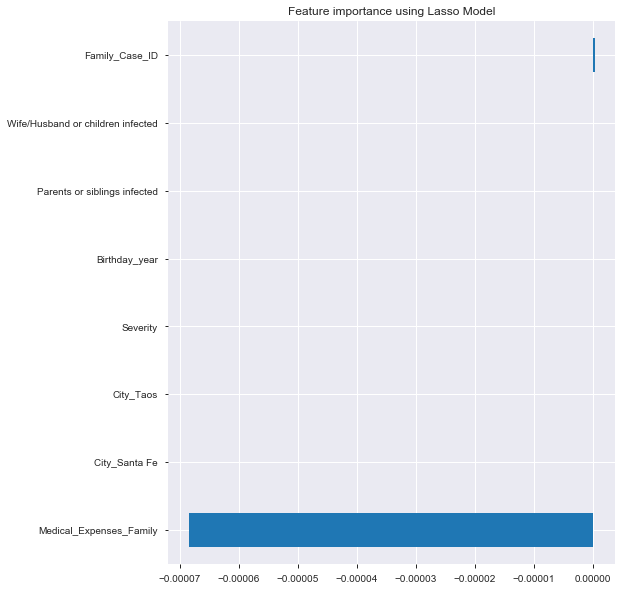

City_Santa Fe                        0.000000e+00
City_Taos                            0.000000e+00
Severity                             0.000000e+00
Birthday_year                        0.000000e+00
Parents or siblings infected         0.000000e+00
Wife/Husband or children infected    0.000000e+00
Family_Case_ID                       3.423313e-07
Medical_Expenses_Family              6.844719e-05
dtype: float64

In [311]:
coef = pd.Series(reg.coef_, index = Independet.columns)
print("Lasso picked " + str(sum(coef != 0)))
%matplotlib inline
# Plot the feature importance determined by Lasso Model
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

plot_importance(coef,'Lasso')
coef.abs().sort_values()

In [312]:
# Extracting features important features according to Lasso Regression
lasso_feat = coef.sort_values().abs() > 0.01
lasso_feat = lasso_feat[lasso_feat].index.values
lasso_feat

array([], dtype=object)

### Ridge

In [313]:
from sklearn.linear_model import RidgeCV

# Ridge Regression
ridge = RidgeCV()
ridge.fit(X = Independet, y = Dependent)
print("Best alpha using built-in RidgeCV: %f" % ridge.alpha_)

Best alpha using built-in RidgeCV: 10.000000


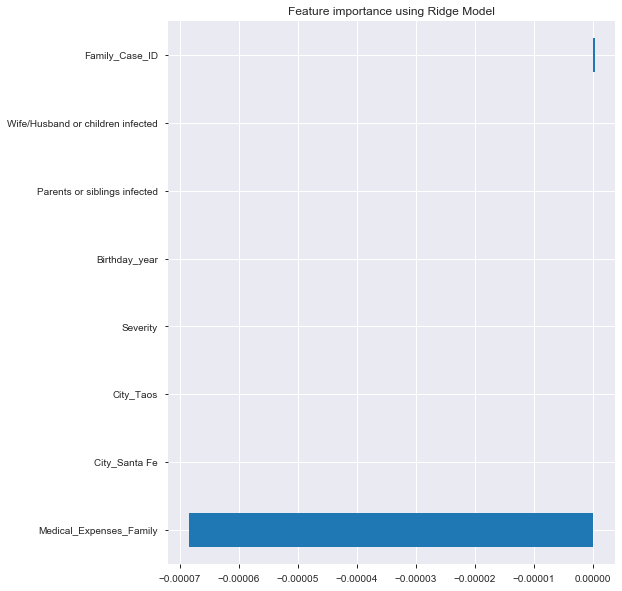

City_Santa Fe                        0.000000e+00
City_Taos                            0.000000e+00
Severity                             0.000000e+00
Birthday_year                        0.000000e+00
Parents or siblings infected         0.000000e+00
Wife/Husband or children infected    0.000000e+00
Family_Case_ID                       3.423313e-07
Medical_Expenses_Family              6.844719e-05
dtype: float64

In [314]:
coef_ridge = pd.Series(reg.coef_, index = Independet.columns)
plot_importance(coef_ridge,'Ridge')
coef_ridge.abs().sort_values()

In [315]:
# Extracting features important features according to Ridge Regression
ridge_feat = coef_ridge.sort_values().abs() > .01
ridge_feat = ridge_feat[ridge_feat].index.values
ridge_feat

array([], dtype=object)

### Correlation between features and target

In [316]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [317]:
A= Independet.merge(Dependent,right_index = True, left_index=True)

In [318]:
# to check if there is any numeric variable that is highly correlated to each other
#therefore, it could be eliminated
correlated_features = set()
correlation_matrix =A.corr(method ='spearman')
cor_feature = []
for i in range(len(correlation_matrix.columns)):
    if abs(correlation_matrix.iloc[i, -1]) > 0.03:
        colname = correlation_matrix.columns[i]
        cor_feature.append(colname)
cor_feature = cor_feature[:-1]
print(cor_feature)

['City_Santa Fe', 'Severity', 'Birthday_year', 'Parents or siblings infected', 'Wife/Husband or children infected', 'Medical_Expenses_Family']


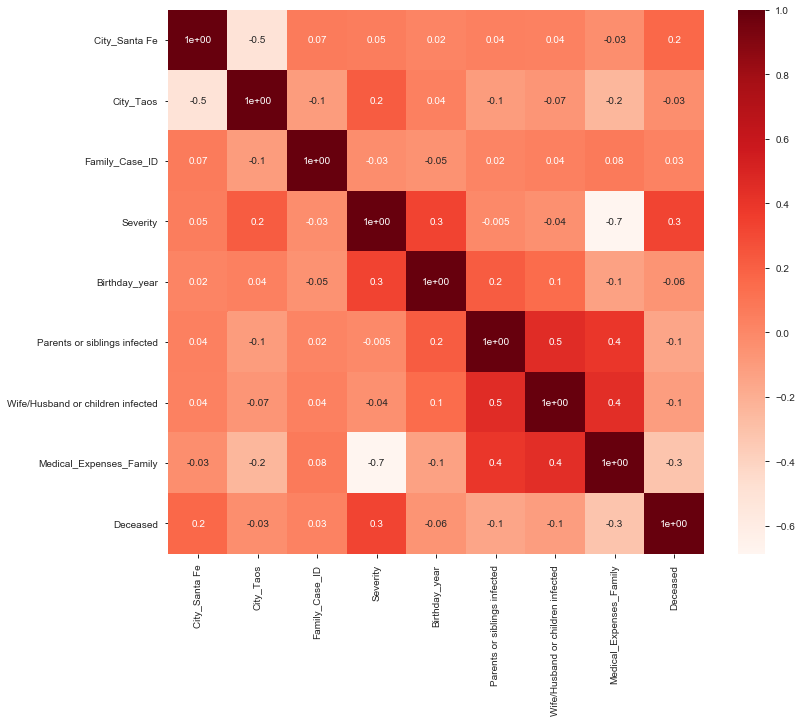

In [319]:
cor_heatmap(A.corr(method ='spearman'))

### Decision tree

-importante features

In [320]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier (random_state=123)

In [321]:
DT.fit(Independet, Dependent)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

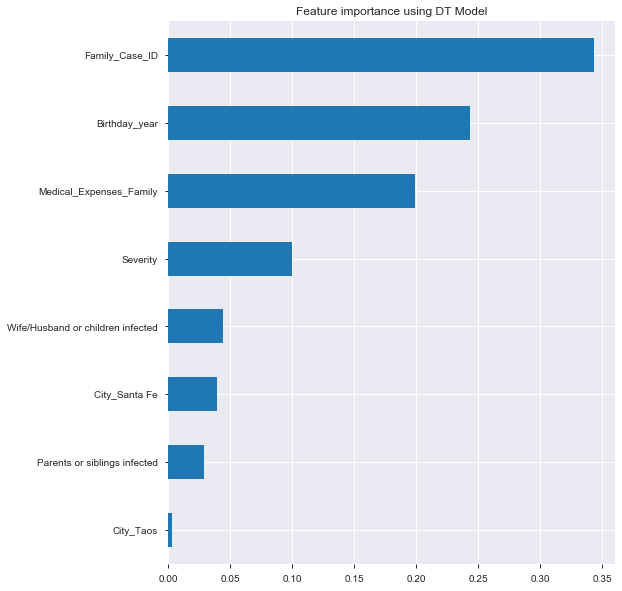

City_Taos                            0.003057
Parents or siblings infected         0.028313
City_Santa Fe                        0.039157
Wife/Husband or children infected    0.043849
Severity                             0.099906
Medical_Expenses_Family              0.198965
Birthday_year                        0.243574
Family_Case_ID                       0.343178
dtype: float64

In [322]:
coef_DT = pd.Series(DT.feature_importances_, index = Independet.columns)
plot_importance(coef_DT,'DT')
coef_DT.abs().sort_values()

In [323]:
# Extracting features important features according to Ridge Regression
DT_feat = coef_DT.sort_values().abs() > .03
DT_feat = DT_feat[DT_feat].index.values
DT_feat

array(['City_Santa Fe', 'Wife/Husband or children infected', 'Severity',
       'Medical_Expenses_Family', 'Birthday_year', 'Family_Case_ID'],
      dtype=object)

### Correlation between features

In [324]:
# to check if there is any numeric variable that is highly correlated to each other
#therefore, it could be eliminated
correlated_features = set()
correlation_matrix =Independet.corr(method ='spearman')
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(len(correlated_features),correlated_features)

0 set()


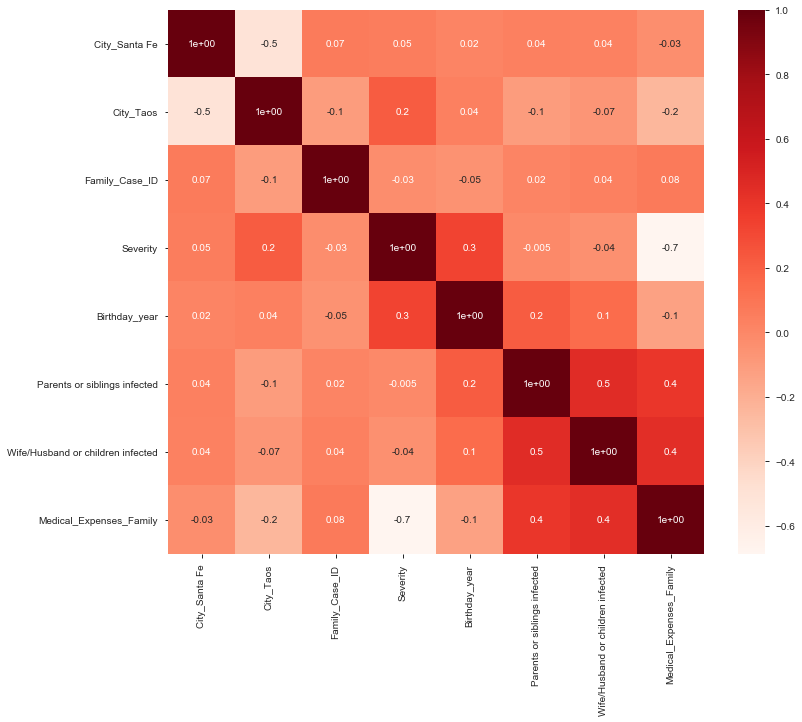

In [325]:
cor_heatmap(Independet.corr(method ='spearman'))

### Selecting features

In [326]:
# Get the repeated features for the 3 criteria
feat_freq = pd.Series(np.concatenate([ lasso_feat, ridge_feat, cor_feature, DT_feat])).value_counts()
feat_freq

Severity                             2
Birthday_year                        2
Medical_Expenses_Family              2
City_Santa Fe                        2
Wife/Husband or children infected    2
Family_Case_ID                       1
Parents or siblings infected         1
dtype: int64

In [327]:
# Get features that fulfil more than 2 criteria
features = feat_freq[feat_freq >= 2]
features = features.index.tolist()
features

['Severity',
 'Birthday_year',
 'Medical_Expenses_Family',
 'City_Santa Fe',
 'Wife/Husband or children infected']

In [330]:
X_train = X_train[features]
X_val = X_val[features]
X = X[features]
X_train.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)
test_ = test_[features]

In [331]:
X.columns

Index(['Severity', 'Birthday_year', 'Medical_Expenses_Family', 'City_Santa Fe',
       'Wife/Husband or children infected'],
      dtype='object')

## Models

- min max MinMaxScaler()
- scalar StandardScaler()
- roboust RobustScaler()


### DT

#### Alpha 

- this whole section is based in https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [332]:
clf = DecisionTreeClassifier(random_state=123)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

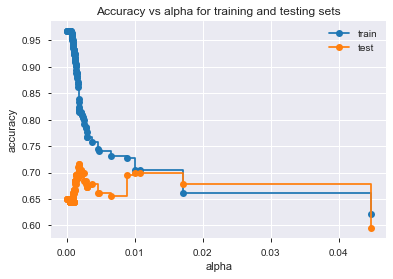

In [333]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

#### GridSearch

In [334]:
# Define default model #['auto','ball_tree','kd_tree','brute']
DT = DecisionTreeClassifier (random_state=123)
        
        
# Create the parameter grid based on the results of random search
param_grid = {
    'ccp_alpha' :[ 0.01],  #float
    'criterion':['gini', 'entropy'], #“gini”, “entropy”  
    #'max_depth':[], #int
     'max_features':['auto', 'sqrt', 'log2'], #“auto”, “sqrt”, “log2”
     #'max_leaf_nodes':[], #int
     #'min_impurity_decrease':[ ] , #float, the split will be made only if descrease the impurity in that float
     # 'min_samples_leaf':[ ] ,  #int or float ( be in the leaf)
     # 'min_samples_split':[ ]  , #int or float ( to make a split)
    #'min_weight_fraction_leaf':[ ]  ,#float
    'splitter':['best', 'random' ]  #“best”, “random”
}                   
                   
# Instantiate the grid search model
grid_DT = GridSearchCV(estimator = DT, param_grid = param_grid, 
                          cv=3)

# Fit grid_RF to training data
grid_DT.fit(X_train, y_train)

# Print parameters for the best score:
print('Best Score: ', round(grid_DT.best_score_, 4))
print('Best Params: ', grid_DT.best_params_)

Best Score:  0.6852
Best Params:  {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}


In [335]:
# Define a  best parameters:
modelDT = DecisionTreeClassifier(ccp_alpha = grid_DT.best_estimator_.get_params()['ccp_alpha'], 
                                criterion = grid_DT.best_estimator_.get_params()['criterion'], 
                                max_features = grid_DT.best_estimator_.get_params()['max_features'], 
                                splitter = grid_DT.best_estimator_.get_params()['splitter'],
                                random_state=123
                                )

In [336]:
modelDT

DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [337]:
modelDT1 = DecisionTreeClassifier(random_state=123)

In [338]:
avg_score(X,y,modelDT1,None )
avg_score(X,y,modelDT,None )

Score for: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Train: 0.9642
Test : 0.6742 

Score for: 
 DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Train: 0.7194
Test : 0.7416 



## model Choise

In [339]:
model = modelDT
#scaler =  MinMaxScaler()
#scaler.fit(X)
#X = pd.DataFrame(scaler.transform(X), columns=X.columns)


In [340]:
model

DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

## PREDICTION

In [344]:
resultado = pd.DataFrame(model.predict(test_),columns=['Deceased'])

In [346]:
test_['Deceased'] = resultado

In [353]:
test_.head(2)

,Severity,Birthday_year,Medical_Expenses_Family,City_Santa Fe,Wife/Husband or children infected,Deceased,Patient_ID
0,3.0,1984.0,203.0,1,0.0,1,901
1,3.0,1988.0,631.0,1,0.0,1,902


In [350]:
test_ = test_.merge(test['Patient_ID'],right_index = True, left_index=True)

In [351]:
test_.columns

Index(['Severity', 'Birthday_year', 'Medical_Expenses_Family', 'City_Santa Fe',
       'Wife/Husband or children infected', 'Deceased', 'Patient_ID'],
      dtype='object')

In [354]:
test_ = test_[['Patient_ID','Deceased' ]]

In [355]:
test_.groupby('Deceased').count()

,Patient_ID
Deceased,
0,123
1,277


In [356]:
#export to csv
test_.to_csv(r'Group_version1.csv', index = False)



In [357]:
check = pd.read_csv('Group_version1.csv', sep =',', skipinitialspace=True)
check.head(2)

,Patient_ID,Deceased
0,901,1
1,902,1
